In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


df = pd.read_csv("base_earnings.csv", index_col = 'Unnamed: 0')
df.Date = pd.to_datetime(df.Date)
#.dt.strftime('%Y-%d-%m')
df.Name = df.Name.str.replace('/d','')
df.Name = df.Name.str.replace(' /d','')

"""df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.week
df['day'] = df['Date'].dt.day"""

df = df.drop(columns= {'RIC', 'mean_estimate'})
#df = df.drop(columns= {'Date', 'Industry', 'Sub-sector', 'Sector'})
df.head()

,Date,revenue,pred_surprise,GDP,Name,Sector,Sub-sector,Industry
1,2008-01-04,1448.000000,-0.123,15752.308,AGILENT TECH,Manufacturing,Computer and Electronic Product Manufacturing,"Navigational, Measuring, Electromedical, and C..."
2,2005-01-10,1194.000000,-0.148,15066.597,AGILENT TECH,Manufacturing,Computer and Electronic Product Manufacturing,"Navigational, Measuring, Electromedical, and C..."
3,2017-01-04,1110.000000,0.003,17995.150,AGILENT TECH,Manufacturing,Computer and Electronic Product Manufacturing,"Navigational, Measuring, Electromedical, and C..."
4,2003-01-01,1448.666667,-0.140,13634.253,AGILENT TECH,Manufacturing,Computer and Electronic Product Manufacturing,"Navigational, Measuring, Electromedical, and C..."
5,2012-01-07,1752.333333,0.129,16220.667,AGILENT TECH,Manufacturing,Computer and Electronic Product Manufacturing,"Navigational, Measuring, Electromedical, and C..."


# Filter by sector/company

In [2]:
pd.value_counts(df.Sector).to_frame().reset_index()

,index,Sector
0,Manufacturing,38670
1,Finance and Insurance,7373
2,"Professional, Scientific, and Technical Services",5865
3,Real Estate and Rental and Leasing,5699
4,Retail Trade,5473
5,Information,5376
6,"Mining, Quarrying, and Oil and Gas Extraction",4099
7,Utilities,3627
8,Transportation and Warehousing,3245
9,Wholesale Trade,2562


In [11]:
pd.value_counts(df['Sub-sector']).to_frame().reset_index()

,index,Sub-sector
0,Computer and Electronic Product Manufacturing,11209
1,Chemical Manufacturing,6093
2,"Professional, Scientific, and Technical Services",5865
3,Real Estate,5410
4,Insurance Carriers and Related Activities,4031
...,...,...
67,Miscellaneous Store Retailers,115
68,Repair and Maintenance,113
69,Animal Production,93
70,Nursing and Residential Care Facilities,91


In [3]:
df_filter = df.loc[df.Date > '2010-01-01']
group1 = df_filter.groupby(['Name','Sector', 'Sub-sector'])[['pred_surprise']].agg(np.mean)
group1 = group1.loc[(group1.pred_surprise < -5) | (group1.pred_surprise > 5)]
group1 = group1.sort_values('pred_surprise')
group1.reset_index(inplace=True)
group1

,Name,Sector,Sub-sector,pred_surprise
0,QUALYS INC,"Professional, Scientific, and Technical Services","Professional, Scientific, and Technical Services",-23.238138
1,CAL-MAINE FOOD,"Agriculture, Forestry, Fishing and Hunting",Animal Production,-13.641853
2,ENANTA PHARMAC,Manufacturing,Chemical Manufacturing,-8.756000
3,SHAKE SHACK IN,Accommodation and Food Services,Food Services and Drinking Places,-7.329185
4,ENDO INTERNATI,Manufacturing,Chemical Manufacturing,-6.595000
5,JOHN BEAN TEC,Manufacturing,Machinery Manufacturing,-6.403088
6,OIL STATES INT,Manufacturing,Machinery Manufacturing,-5.924765
7,GARRET MOTIN I,Manufacturing,Transportation Equipment Manufacturing,-5.019429
8,LEGGETT& PLATT,Manufacturing,Furniture and Related Product Manufacturing,21.474824


### by name

In [4]:
df_reg = df.loc[df.Name.isin(group1.Name)]
df_reg = df_reg.drop(columns= {'Sub-sector', 'Industry', 'pred_surprise','Sector'})
df_reg = df_reg.sort_values('Date')
#df_reg['GDP_var'] = df_reg['GDP'].pct_change(1)
df_reg['revenue_var'] = df_reg['revenue'].pct_change(1)
df_reg = df_reg.drop(columns= {'Date', 'revenue_var'})
df_reg = df_reg.replace([np.inf, -np.inf], np.nan)
df_reg.dropna(inplace= True)
df_reg.reset_index(inplace= True, drop= True)
df_reg

,revenue,GDP,Name
0,266.916,9358.289,LEGGETT& PLATT
1,277.105,9392.251,LEGGETT& PLATT
2,285.004,9398.499,LEGGETT& PLATT
3,259.599,9312.937,LEGGETT& PLATT
4,263.153,9269.367,LEGGETT& PLATT
...,...,...,...
460,119.647,18664.973,SHAKE SHACK IN
461,784.000,18664.973,GARRET MOTIN I
462,1091.500,18664.973,LEGGETT& PLATT
463,274.594,18664.973,OIL STATES INT


In [6]:
names = df_reg.Name.unique()
row_index = 0
acc_d = []

for i in range(len(names)):
    company = df_reg[df_reg.Name == names[i]]
    company = company[company != 'inf']
    X = company.GDP.values.reshape(-1, 1)
    y = company.revenue.values.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 
    regressor = LinearRegression()
    regressor.fit(X_train,y_train)
    
    acc_train = round(regressor.score(X_train, y_train), 4)
    acc_test = round(regressor.score(X_train, y_train), 4)
    acc_d.append([acc_train, acc_test])
    
    row_index+=1

    #Predicting the Test set results
    y_pred = regressor.predict(X_test)

df_accuracy = pd.DataFrame(acc_d, index = names, columns = ['train','test'])
df_accuracy.sort_values('train', ascending=False)[0:10]   

,train,test
QUALYS INC,0.9782,0.9782
SHAKE SHACK IN,0.9575,0.9575
ENDO INTERNATI,0.9411,0.9411
CAL-MAINE FOOD,0.7192,0.7192
JOHN BEAN TEC,0.7010,0.7010
GARRET MOTIN I,0.6932,0.6932
ENANTA PHARMAC,0.5155,0.5155
LEGGETT& PLATT,0.5021,0.5021
OIL STATES INT,0.0449,0.0449


### by sector

In [7]:
#df_reg = df.loc[df.Name.isin(group1.Name)]
df_reg = df.drop(columns= {'Sub-sector', 'Industry', 'pred_surprise','Name'})
df_reg = df_reg.sort_values('Date')
#df_reg['GDP_var'] = df_reg['GDP'].pct_change(1)
df_reg['revenue_var'] = df_reg['revenue'].pct_change(1)
df_reg = df_reg.drop(columns= {'Date', 'revenue_var'})
df_reg = df_reg.replace([np.inf, -np.inf], np.nan)
df_reg.dropna(inplace= True)
df_reg.reset_index(inplace= True, drop= True)

names = df_reg.Sector.unique()
row_index = 0
acc_d = []

for i in range(len(names)):
    company = df_reg[df_reg.Sector == names[i]]
    X = X[X != 'inf']
    X = company.GDP.values.reshape(-1, 1)
    y = company.revenue.values.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 
    regressor = LinearRegression()
    regressor.fit(X_train,y_train)
    
    acc_train = round(regressor.score(X_train, y_train), 4)
    acc_test = round(regressor.score(X_train, y_train), 4)
    acc_d.append([acc_train, acc_test])
    
    row_index+=1

    #Predicting the Test set results
    y_pred = regressor.predict(X_test)

df_accuracy = pd.DataFrame(acc_d, index = names, columns = ['train','test'])
df_accuracy.sort_values('train', ascending=False)[0:10]   

,train,test
"Agriculture, Forestry, Fishing and Hunting",0.7192,0.7192
Other Services (except Public Administration),0.1579,0.1579
Construction,0.0912,0.0912
Utilities,0.0895,0.0895
Real Estate and Rental and Leasing,0.0784,0.0784
Transportation and Warehousing,0.0683,0.0683
Administrative and Support and Waste Management and Remediation Services,0.0643,0.0643
Wholesale Trade,0.0505,0.0505
Health Care and Social Assistance,0.0463,0.0463
Educational Services,0.0423,0.0423


# Test autres algos

In [71]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report,accuracy_score 


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,confusion_matrix
from sklearn import ensemble, linear_model, neighbors, svm, tree
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process


In [119]:
df_reg = df.loc[df.Name.isin(group1.Name)]
df_reg = df_reg.drop(columns= {'Sub-sector', 'Industry','Sector'})
df_reg = df_reg.sort_values('Date')
df_reg['GDP_var'] = df_reg['GDP'].pct_change(1)
df_reg['revenue_var'] = df_reg['revenue'].pct_change(1)
#df_reg['revenue_var'] = df_reg['revenue_var']>0
df_reg = df_reg.drop(columns= {'Date'})
df_reg = df_reg.replace([np.inf, -np.inf], np.nan)
df_reg.dropna(inplace= True)
df_reg.reset_index(inplace= True, drop= True)
df_reg

,revenue,pred_surprise,GDP,Name,GDP_var,revenue_var
0,277.105000000,-51.468000000,"9,392.251000000",LEGGETT& PLATT,0.003629082,0.038173058
1,285.004000000,-51.468000000,"9,398.499000000",LEGGETT& PLATT,0.000665229,0.028505440
2,259.599000000,-51.468000000,"9,312.937000000",LEGGETT& PLATT,-0.009103794,-0.089139100
3,263.153000000,-51.468000000,"9,269.367000000",LEGGETT& PLATT,-0.004678438,0.013690345
4,282.895000000,-51.468000000,"9,341.642000000",LEGGETT& PLATT,0.007797188,0.075020995
...,...,...,...,...,...,...
458,119.647000000,-7.698000000,"18,664.973000000",SHAKE SHACK IN,0.000000000,0.780328845
459,784.000000000,-5.136000000,"18,664.973000000",GARRET MOTIN I,0.000000000,5.552608925
460,"1,091.500000000",-8.085000000,"18,664.973000000",LEGGETT& PLATT,0.000000000,0.392219388
461,274.594000000,-3.952000000,"18,664.973000000",OIL STATES INT,0.000000000,-0.748425103


In [120]:
MLA = [
    #neighbors.KNeighborsRegressor(),
    svm.SVR(),
    svm.LinearSVR(),
    tree.DecisionTreeRegressor(),
    LinearRegression(),
    RandomForestRegressor(n_estimators = 500,random_state =0)
    ]

In [127]:
names = df_reg.Name.unique()
row_index = 0
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
acc_d = []

for alg in MLA:
    for i in range(len(names)):
        company = df_reg[df_reg.Name == names[i]]
        company = company[company != 'inf']
        X = company.GDP.values.reshape(-1, 1)
        y = company.revenue.values.reshape(-1, 1)
        pred_surprise = np.mean(company.pred_surprise)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 
        regressor = alg
        regressor.fit(X_train,y_train)
        # acc_train = regressor.score(X_train, y_train)
#         acc_test = regressor.score(X_train, y_train)
        y_pred = regressor.predict(X_test)
        
        # Calculate the absolute errors
        errors = abs(y_pred - y_test)
        acc_test = 1 - np.mean((errors / y_test))

        our_pred = 100 *np.mean((y_pred - y_test)/y_test)
        
        acc_d.append([names[i],alg.__class__.__name__, acc_test, pred_surprise, our_pred, len(y_pred)])
        
pd.options.display.float_format = '{:,.9f}'.format
df_accuracy = pd.DataFrame(acc_d, columns = ['Name','Algo','test','pred_surprise', 'our_pred', 'len'])
df_accuracy.sort_values('test', ascending=False)

,Name,Algo,test,pred_surprise,our_pred,len
32,QUALYS INC,LinearRegression,0.955582367,-23.238137931,-2.125472616,9
26,GARRET MOTIN I,DecisionTreeRegressor,0.930560061,-5.019428571,6.517836340,3
44,GARRET MOTIN I,RandomForestRegressor,0.913445986,-5.019428571,8.655401367,3
8,GARRET MOTIN I,SVR,0.906255137,-5.019428571,9.374486302,3
35,GARRET MOTIN I,LinearRegression,0.896552762,-5.019428571,10.344723787,3
4,JOHN BEAN TEC,SVR,0.831215856,-5.269638298,2.845231358,15
34,SHAKE SHACK IN,LinearRegression,0.821748081,-7.329185185,-1.767942074,9
17,GARRET MOTIN I,LinearSVR,0.812164879,-5.019428571,18.783512133,3
31,JOHN BEAN TEC,LinearRegression,0.809823598,-5.269638298,9.042135761,15
13,JOHN BEAN TEC,LinearSVR,0.800124124,-5.269638298,-17.827522159,15


__look at algo score__

In [113]:
group_by_algo = df_accuracy.groupby(['Name','Algo'])[['test']].sum()
group_by_algo

test
Name           Algo                              
CAL-MAINE FOOD DecisionTreeRegressor  0.051853996
               LinearRegression       0.666228509
               LinearSVR              0.098135292
               RandomForestRegressor  0.058829896
               SVR                    0.371926959
ENANTA PHARMAC DecisionTreeRegressor -0.414198792
               LinearRegression      -0.035029399
               LinearSVR              0.375629758
               RandomForestRegressor -0.132558267
               SVR                    0.259949178
ENDO INTERNATI DecisionTreeRegressor -0.686882735
               LinearRegression       0.734033125
               LinearSVR             -2.926415146
               RandomForestRegressor -0.661405721
               SVR                    0.177415194
GARRET MOTIN I DecisionTreeRegressor  0.930560061
               LinearRegression       0.896552762
               LinearSVR              0.950523826
               RandomForestRegressor  0.913445986
               SVR                    0.906255137
JOHN BEAN TEC  DecisionTreeRegressor  0.755079924
               LinearRegression       0.809823598
               LinearSVR              0.835047085
               RandomForestRegressor  0.748985186
               SVR                    0.831215856
LEGGETT& PLATT DecisionTreeRegressor  0.344105833
               LinearRegression       0.638511322
               LinearSVR              0.449976920
               RandomForestRegressor  0.334493697
               SVR                    0.356422362
OIL STATES INT DecisionTreeRegressor  0.330720591
               LinearRegression       0.467913297
               LinearSVR              0.510427372
               RandomForestRegressor  0.286383598
               SVR                    0.527778360
QUALYS INC     DecisionTreeRegressor  0.483027193
               LinearRegression       0.955582367
               LinearSVR              0.592980087
               RandomForestRegressor  0.501786671
               SVR                    0.618894067
SHAKE SHACK IN DecisionTreeRegressor  0.075216990
               LinearRegression       0.821748081
               LinearSVR             -0.815772937
               RandomForestRegressor  0.109940066
               SVR                    0.452397404

In [114]:
df_accuracy[df_accuracy.test>0.7]

,Name,Algo,test,y_test,y_pred,len
4,JOHN BEAN TEC,SVR,0.831215856,"[[198.0], [254.6], [243.2], [260.2], [230.3], ...","[260.37191926084, 267.2956035696353, 264.12021...",15
8,GARRET MOTIN I,SVR,0.906255137,"[[784.0], [745.0], [775.0]]","[840.6143784794305, 839.2765429973409, 838.894...",3
13,JOHN BEAN TEC,LinearSVR,0.835047085,"[[198.0], [254.6], [243.2], [260.2], [230.3], ...","[229.92266787532978, 240.64762234906314, 235.6...",15
17,GARRET MOTIN I,LinearSVR,0.950523826,"[[784.0], [745.0], [775.0]]","[823.4656262356481, 799.4595720362191, 793.914...",3
22,JOHN BEAN TEC,DecisionTreeRegressor,0.755079924,"[[198.0], [254.6], [243.2], [260.2], [230.3], ...","[233.5, 273.3, 273.3, 216.5, 252.5, 234.5, 386...",15
26,GARRET MOTIN I,DecisionTreeRegressor,0.930560061,"[[784.0], [745.0], [775.0]]","[877.0, 804.0, 772.0]",3
29,ENDO INTERNATI,LinearRegression,0.734033125,"[[217.125], [290.27099999999996], [240.7890000...","[[312.9749854972747], [355.56789133946336], [2...",13
31,JOHN BEAN TEC,LinearRegression,0.809823598,"[[198.0], [254.6], [243.2], [260.2], [230.3], ...","[[286.4833367918295], [338.5263782589416], [31...",15
32,QUALYS INC,LinearRegression,0.955582367,"[[21.191], [50.986999999999995], [55.302], [36...","[[20.826689121222614], [49.705290679694656], [...",9
34,SHAKE SHACK IN,LinearRegression,0.821748081,"[[16.07], [99.116], [53.273], [66.472], [20.95...","[[6.820219003845864], [99.1782679200902], [60....",9


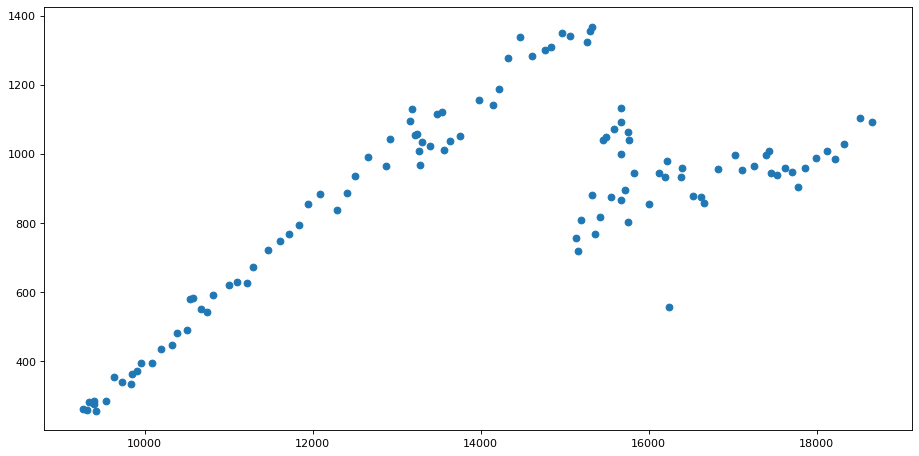

In [92]:
fig=plt.figure(figsize=(14, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(df_reg[df_reg.Name == 'LEGGETT& PLATT']['GDP'],
            df_reg[df_reg.Name == 'LEGGETT& PLATT']['revenue'])


In [85]:
pd.DataFrame([df_accuracy[df_accuracy.Name == 'LEGGETT& PLATT']['y_pred'][18],
              df_accuracy[df_accuracy.Name == 'LEGGETT& PLATT']['y_test'][27]]).T

,0,1
0,960.300000000,[903.7]
1,363.000000000,[333.82300000000004]
2,628.600000000,[620.0]
3,285.004000000,[284.709]
4,984.500000000,[1009.7]
5,"1,187.200000000",[1278.1]
6,"1,355.600000000",[1323.8]
7,718.100000000,[757.4]
8,673.200000000,[626.4]
9,282.895000000,[259.599]


In [43]:
df_accuracy[df_accuracy.Name == 'LEGGETT& PLATT']['y_test'][27]

array([[ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [136]:
import plotly.graph_objects as go

fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=df_accuracy.index,
                         y=abs(df_accuracy.our_pred),
                        mode='lines+markers',
                        name='notre prediction'))
fig.add_trace(go.Scatter(x=df_accuracy.index,
                         y=abs(df_accuracy.pred_surprise),
                    mode='lines+markers',
                    name='prediction des analystes'))


fig.show()

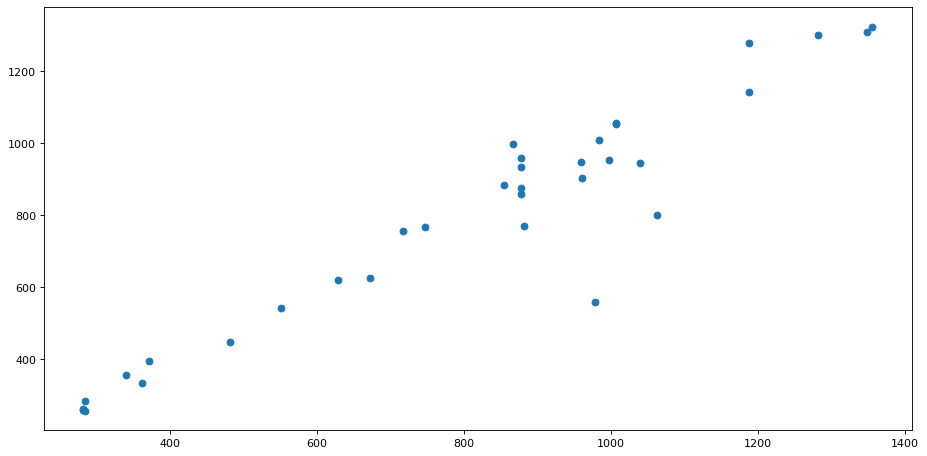

In [95]:
fig=plt.figure(figsize=(14, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(df_reg[df_accuracy.index == df_reg.index]['pred_surprise'][18],
            df_accuracy[df_accuracy.Name == 'LEGGETT& PLATT']['y_test'][18])

In [96]:
df_reg[df_reg.index == df_accuracy.index]['pred_surprise'][18]

ValueError: Lengths must match to compare

In [117]:
df_accuracy.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], dtype=int64)